In [1]:
import fonctions
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="white")

df_players = pd.read_parquet('df_players.parquet')
df_players = df_players.reset_index()  # Indices alignés

n_last_matches = 1

In [2]:
# Exemple : récupérer et visualiser les données sur les X derniers matchs
df_transfers = fonctions.get_recent_transfers(df_players, n_last_matches)

In [3]:
# Trier pour garder les plus gros mouvements
df_transfers_sorted = df_transfers.sort_values(by='total_transfers', ascending=False).head(30)

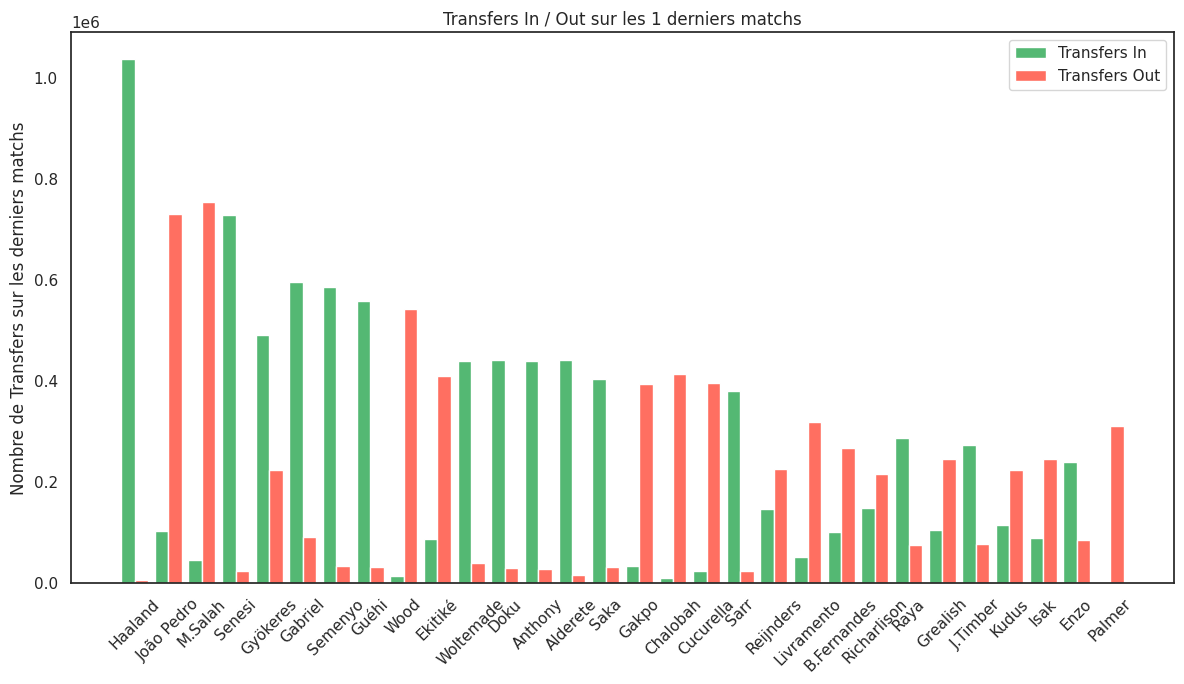

In [4]:
# Graphique Barres côte à côte
fig, ax = plt.subplots(figsize=(12, 7))

bar_width = 0.4
indices = range(len(df_transfers_sorted))

ax.bar(indices, df_transfers_sorted['transfers_in'], width=bar_width, label='Transfers In', color= '#54B873')
ax.bar([i + bar_width for i in indices], df_transfers_sorted['transfers_out'], width=bar_width, label='Transfers Out', color= '#FF6F61')

ax.set_xticks([i + bar_width / 2 for i in indices])
ax.set_xticklabels(df_transfers_sorted['web_name'], rotation=45, ha='center')

ax.set_ylabel('Nombre de Transfers sur les derniers matchs')
ax.set_title(f'Transfers In / Out sur les {n_last_matches} derniers matchs')
ax.legend()

plt.tight_layout()
plt.show()

In [5]:
# Trier pour garder les plus gros mouvements
df_players["total_transfers"] = (df_players["transfers_in_event"] + df_players["transfers_out_event"])
df_players_sorted = df_players.sort_values(by='total_transfers', ascending=False).head(30)

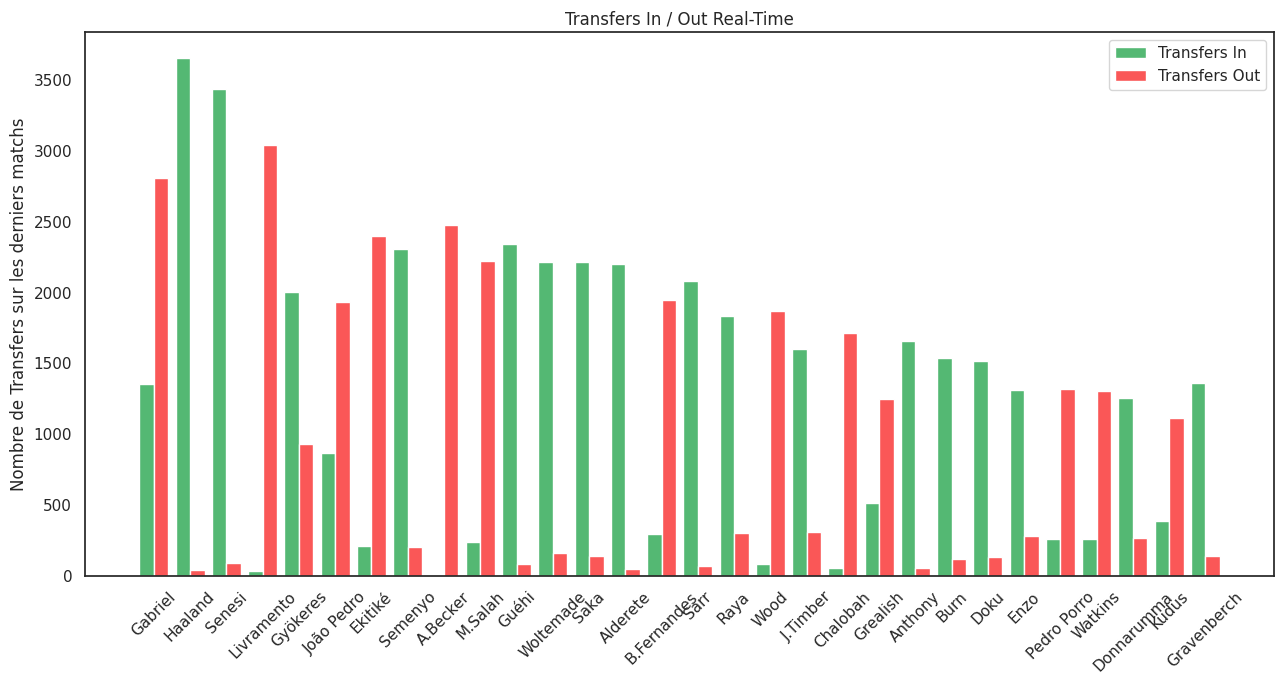

In [6]:
# Graphique Barres côte à côte
fig, ax = plt.subplots(figsize=(13, 7))

bar_width = 0.4
indices = range(len(df_players_sorted))

ax.bar(indices, df_players_sorted['transfers_in_event'], width=bar_width, label='Transfers In', color= '#54B873')
ax.bar([i + bar_width for i in indices], df_players_sorted['transfers_out_event'], width=bar_width, label='Transfers Out', color= '#FA5757')

ax.set_xticks([i + bar_width / 2 for i in indices])
ax.set_xticklabels(df_players_sorted['web_name'], rotation=45, ha='center')

ax.set_ylabel('Nombre de Transfers sur les derniers matchs')
ax.set_title(f'Transfers In / Out Real-Time')
ax.legend()

plt.tight_layout()
plt.show()

In [7]:
# 1. Choisir les ids des joueurs à suivre (top joueurs)
top_player_ids = df_players.sort_values("selected", ascending=False).head(20)['id'].tolist()

history_data = []

for player_id in top_player_ids:
    url = f"https://fantasy.premierleague.com/api/element-summary/{player_id}/"
    resp = requests.get(url).json()
    web_name = df_players.loc[df_players['id'] == player_id, 'web_name'].values[0]
    for h in resp['history']:
        gw = h['round']
        selected = int(h.get('selected', 0))
        history_data.append({
            "web_name": web_name,
            "gameweek": gw,
            "selected": selected
        })

df_sel = pd.DataFrame(history_data)

# (Optionnel) Applique un pourcentage du nombre total de managers
total_managers = 10000000  # à actualiser selon saison
df_sel['selected_pct'] = 100 * df_sel['selected'] / total_managers

# 2. Filtrer les x dernières GW (exemple : 8 dernières GWs)
last_n = 8
max_gw = df_sel['gameweek'].max()
df_sel = df_sel[df_sel['gameweek'] > max_gw - last_n]

# 3. Visualisation
sns.set_theme(style="whitegrid")
plt.figure(figsize=(13,7))
sns.lineplot(
    data=df_sel, 
    x="gameweek", 
    y="selected_pct", 
    hue="web_name", 
    marker="o",
    linewidth=2
)
plt.title(f"Évolution du % selected pour les top joueurs sur les {last_n} dernières Gameweeks", fontsize=15, fontweight="bold")
plt.xlabel("Gameweek")
plt.ylabel("% des managers ayant le joueur", fontsize=13)
plt.legend(title='Joueur', fontsize=12)
plt.tight_layout()
plt.show()


KeyError: 'selected'